In [1]:
%load_ext autoreload
%autoreload 1
%aimport scorer_class
import numpy as np
import pandas as pd
from copy import deepcopy
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## preprocessing params
window_sec1 = 10                                                            # analysis window (sec)
n_hours_cycle = 12                                                          # analysis chunk for NREM identification (hours)
skip_minutes = [0, 0, 0, 0, 0, 0, 0, 0, 0]                                  # how many minutes to skip in the recording begining (channel/animal-wise; file-wise and day-wise options are not implemented) 
pre_filt = False                                                            # lower frequency for high-pass prefiltering; can be False/None if filtering is not required
filt_params = {'length': 1501, 'transition': 0.6, 'window': 'kaiser'}       # filter characteristics in case pre_filt is activated
cluster_artifact = 'outside_ridges'                                         # whether to use additional normal-amplitude artifacts removal for all data ('everywhere'), only among reduced wake epochs ('outside_ridges'), or don't (False/None)

# NREM identification params
visualize_clusters = False                                                  # whether to plot delta/sigma scatters used for NREM identification
smooth_fft = 30                                                             # smoothing window (sec) for smoothing along epoch/time axis to delta/sigma spectra before NREM identification; can be False/None
delta_cluster_bands = ((2, 16), (2, 4), (3, 5), (2, 5), (12, 14), (14, 16)) # delta/sigma bands for NREM identification
w_nr_cluster_strictness = 0.5                                               # decision threshold in the NREM identification voting (0.5 -> simple majority voting)

# contextual rules
single_nr = 2                                                               # whether to remove NREM episodes shorter or equal to (True/int) or not (Faalse/None)
single_wake = False                                                         # whether to remove Wake episodes shorter or equal to (True/int) or not (Faalse/None)
single_r = True                                                             # whether to remove REM episodes shorter or equal to (True/int) or not (Faalse/None)
single_nrem2_1_2 = True                                                     # whether to remove single NREM betwen REMs
single_wake2_0_2 = True                                                     # Whether to remove single Wake betwen REMs

# post analysis
n_hours_cycle_bars = 12                                                     # how many hours to use for separate stage presence barplots 
minutes = 60                                                                # how many minutes to use for averaging stage presence percentage saved to csv file
hours_fragm = 12                                                            # how many hours to use for counting fragmentation stats saved to csv file

# misc
spindles = False                                                            # experimental, for now better be False/None (whether to detect abnormal theta spindles as a separate stage)
verbose = 1                                                                 # verbosity levels (0-2) - how many graphs are plotted

# dirs
dir_ = r"G:\LA\data"                                                        # source directory
fnames = [r'mouse_1.smr']                                                   # data files names
save_dir = dir_                                                             # where the analysis results will be stored
scorer_class.DATA_EXTENSION = fnames[0].split('.')[-1]

hypno_fnames = [r'mouse_1.txt']                                             # expert hypnograms filenames (if necessary/available); must be fully identical to data file names except extension
expert_hypnos = None if len(hypno_fnames) == 0 \
                else scorer_class.read_hypnos(hypno_fnames, dir_)           # if loading expert hypnograms, header si of format 'AnimalIndex_DayIndex', each column is for <=24 hours, 1 label should correspond to window_sec1 epoch

# for flexibility, some params are further set right where they are applied, which facilitates re-running cells when params are adjusted

Expert hypnogram:  G:\LA\data\mouse_1.txt stages presented:  [0 1 2 3 8]


In [3]:
# BCs for mice
delta_theta_combs = [   [(6, 10), (2, 10)], [(6, 9), (2, 10)],  [(6, 9), (2, 9)],   [(6, 10), (2, 9)],  [(6, 10), (2, 8)],  [(6, 10), (2, 11)],
                        [(6, 9), (2, 11)],  [(6, 9), (2, 8)],   [(6, 9), (2, 7)],   [(6, 10), (2, 16)], [(6, 10), (2, 7)],  [(6, 9), (3, 10)],
                        [(5, 9), (2, 10)],  [(6, 10), (2, 12)], [(6, 10), (3, 10)], [(6, 10), (2, 13)], [(6, 10), (2, 15)], [(6, 10), (2, 14)],
                        [(5, 10), (2, 10)], [(6, 10), (3, 7)],  [(5, 9), (2, 11)],  [(6, 9), (2, 12)],  [(6, 9), (2, 14)],  [(6, 10), (3, 5)],
                        [(6, 9), (2, 16)],  [(6, 10), (2, 5)],  [(6, 9), (2, 5)],   [(6, 10), (2, 6)],  [(6, 9), (2, 6)],   [(6, 9), (2, 13)]]

In [ ]:
## BCs for rats
# delta_theta_combs = [[(5, 9), (2, 4)],  [(5, 9), (2, 5)],  [(5, 8), (2, 4)],  [(5, 8), (2, 5)], [(5, 10), (2, 5)], [(5, 9), (3, 5)],
#                      [(6, 9), (2, 4)],  [(6, 8), (2, 4)],  [(5, 9), (2, 6)],  [(6, 9), (2, 5)], [(6, 8), (2, 5)],  [(5, 8), (3, 5)],
#                      [(5, 8), (2, 6)],  [(5, 10), (3, 5)], [(5, 10), (2, 4)], [(6, 9), (3, 5)], [(5, 10), (2, 6)], [(5, 9), (2, 7)],
#                      [(6, 9), (2, 6)],  [(6, 8), (3, 5)],  [(6, 8), (2, 6)],  [(5, 8), (2, 7)], [(6, 10), (2, 5)], [(6, 10), (2, 4)],
#                      [(5, 10), (2, 7)], [(6, 10), (2, 6)], [(6, 10), (3, 5)], [(6, 9), (2, 7)], [(5, 9), (3, 6)],  [(6, 8), (2, 7)],]

# Preprocessing:
### - data is split into 24-hour chunks, sampling rate is rounded to the closest integer if necessary, then pre-filtering is applied if pre_filt was set accordingly;  
### - FFT spectra are calculated, those for NREM identification are  smoothed along time if smooth_fft was set accordingly
### - Raw signal RMS is calculated and smoothed for the first time with the predefined window of 20 s

In [4]:
hypno_labels, last_hypnos, fracs, fragms, hypnos, saved_specs = {}, {}, {}, {}, {}, {} # initialize the variables where the interim results will be stored
vote_dict, scoring, scorings = scorer_class.prescoring(fnames, dir_, window_sec1=window_sec1, n_hours_cycle=n_hours_cycle, delta_cluster_bands=delta_cluster_bands, verbose=verbose, filt_params=filt_params, pre_filt=pre_filt, \
                                                       cluster_strictness=w_nr_cluster_strictness, smooth_fft=smooth_fft, cluster_artifact=cluster_artifact, skip_minutes=skip_minutes)

File "mouse_1.smr"
Animal 0
Day 0
Non-integer sampling rate 193.5734 correction started... Done.
24.00 hours of data loaded. 2 cycles of 12 hours each, sf = 194
Preparing data...smoothing deltas... Done
smoothing raw RMS... Done.


### - 2 types of artifact detection (if cluster_artifact is enabled) and Wake epochs reduction

File "mouse_1.smr"
Animal 0
Day 0


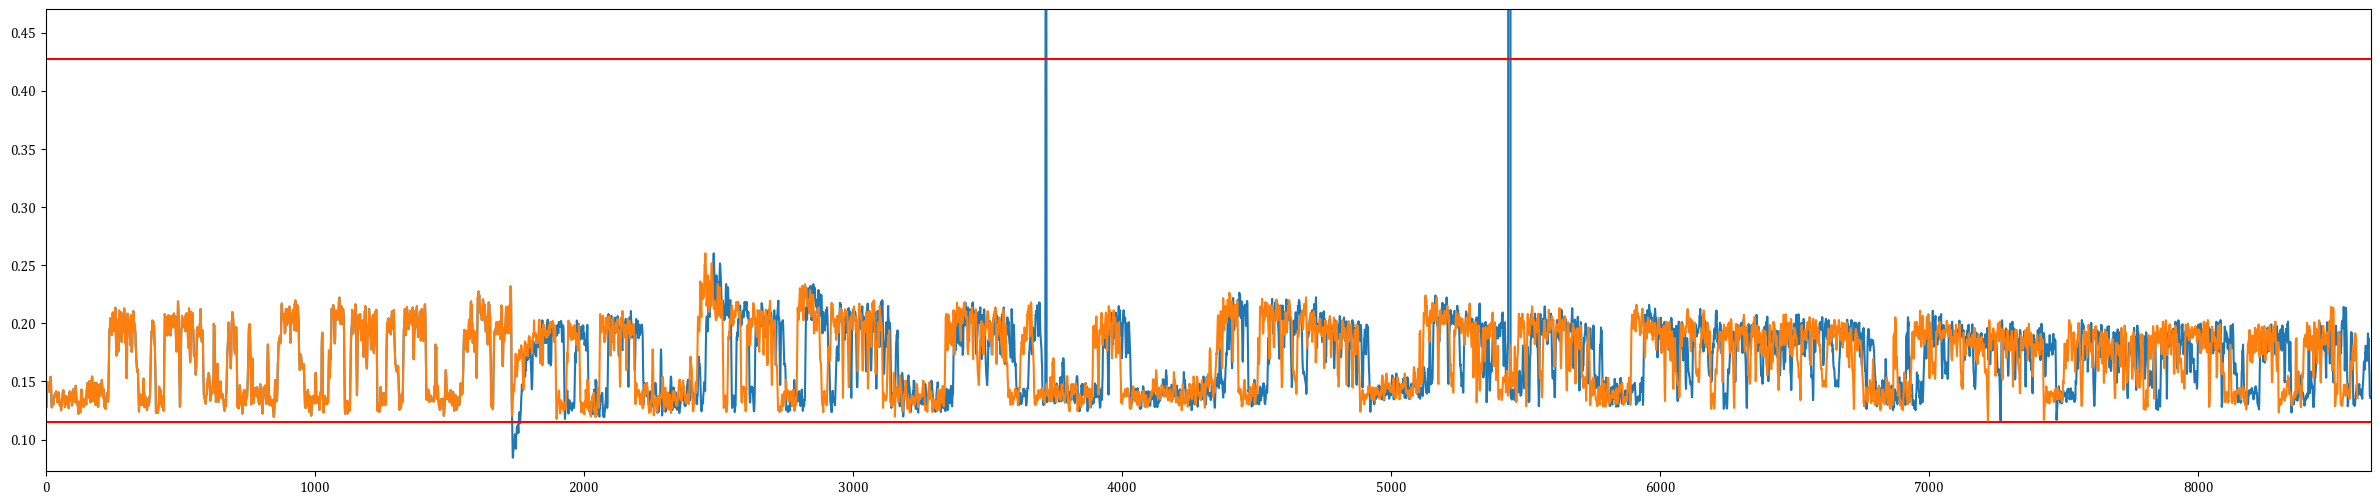

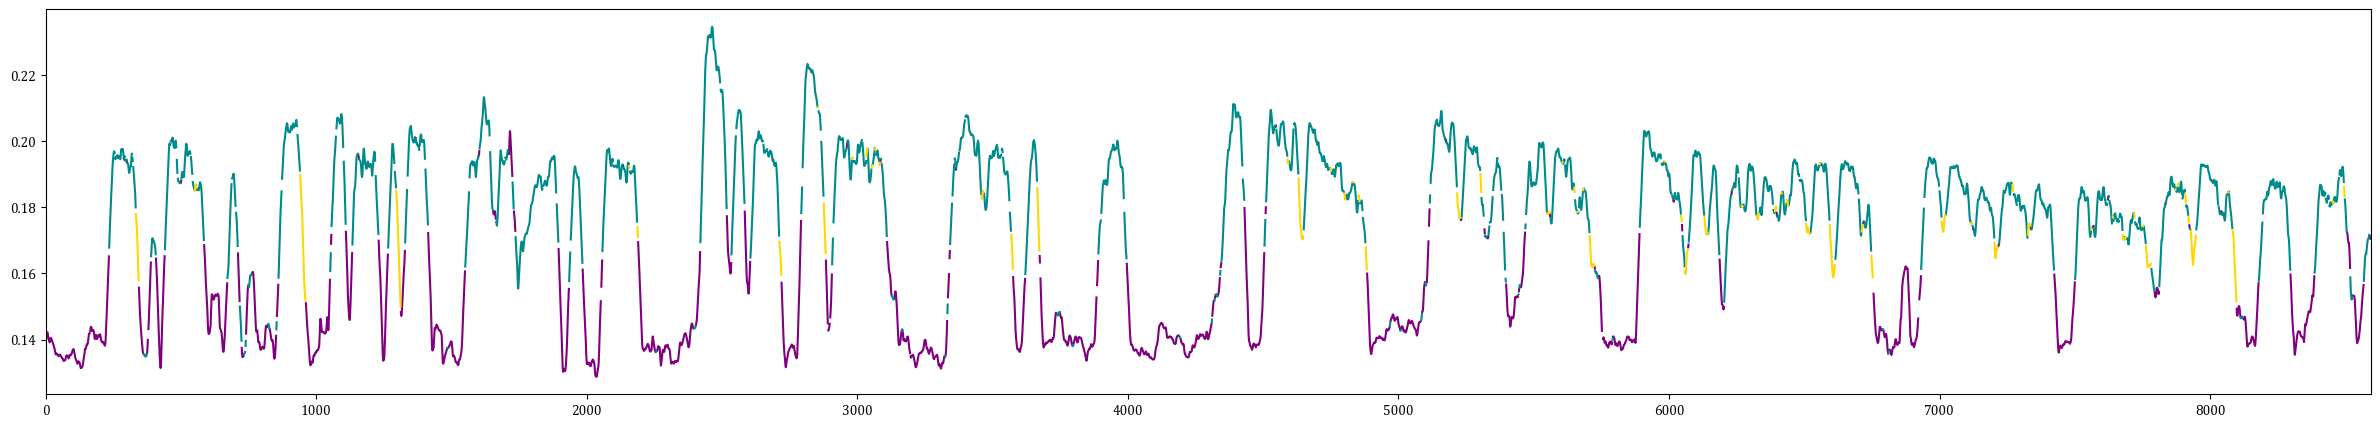

1th threshold too high 0.15 (lower mean = 0.139, upper mean = 0.186, range = 0.048), lowering to 0.143
2th threshold too high 0.16 (lower mean = 0.143, upper mean = 0.183, range = 0.040), lowering to 0.147


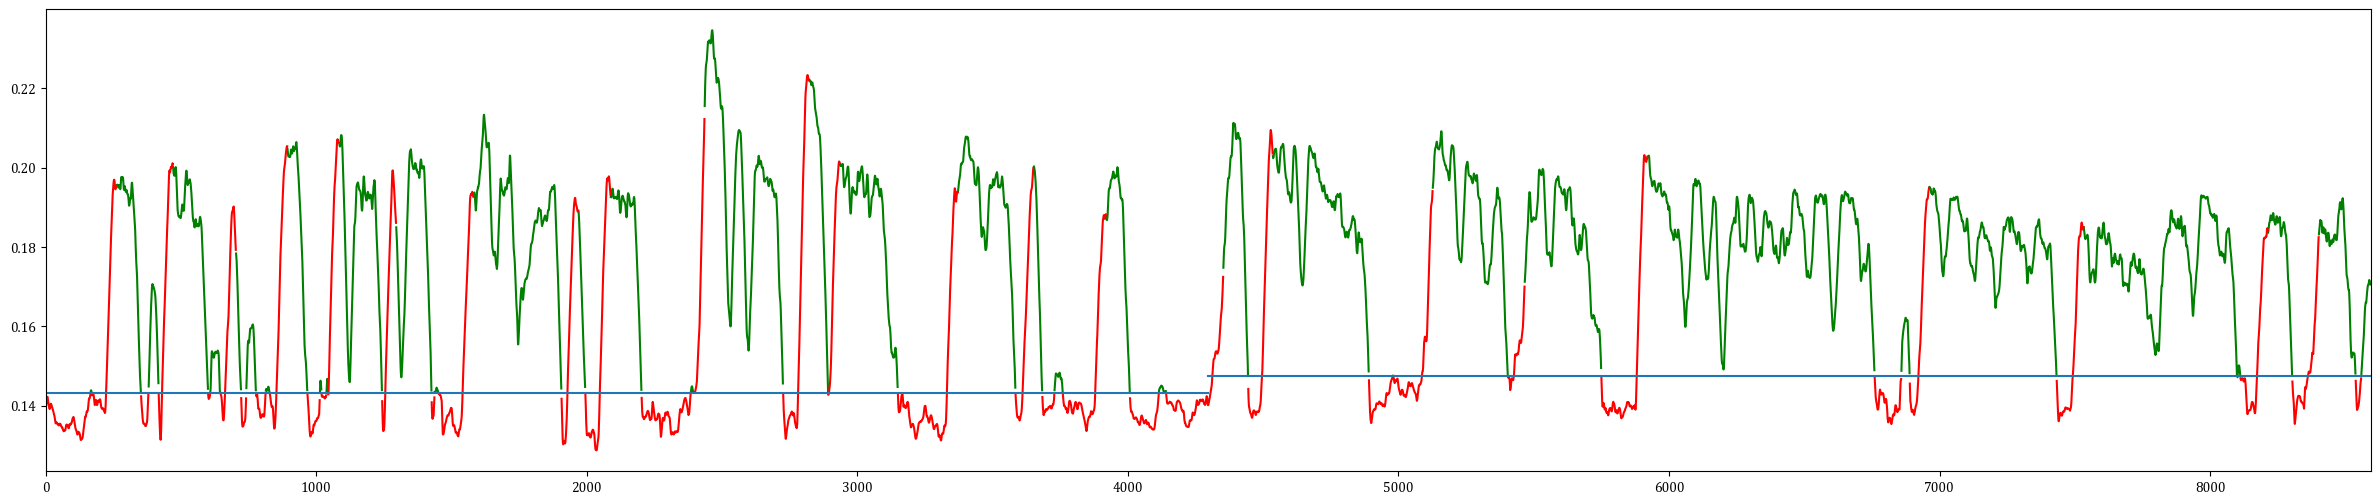

2248 wakes removed by threshold (ridges)
960 epochs removed after threshold intersection
3208 epochs removed in total by ridges


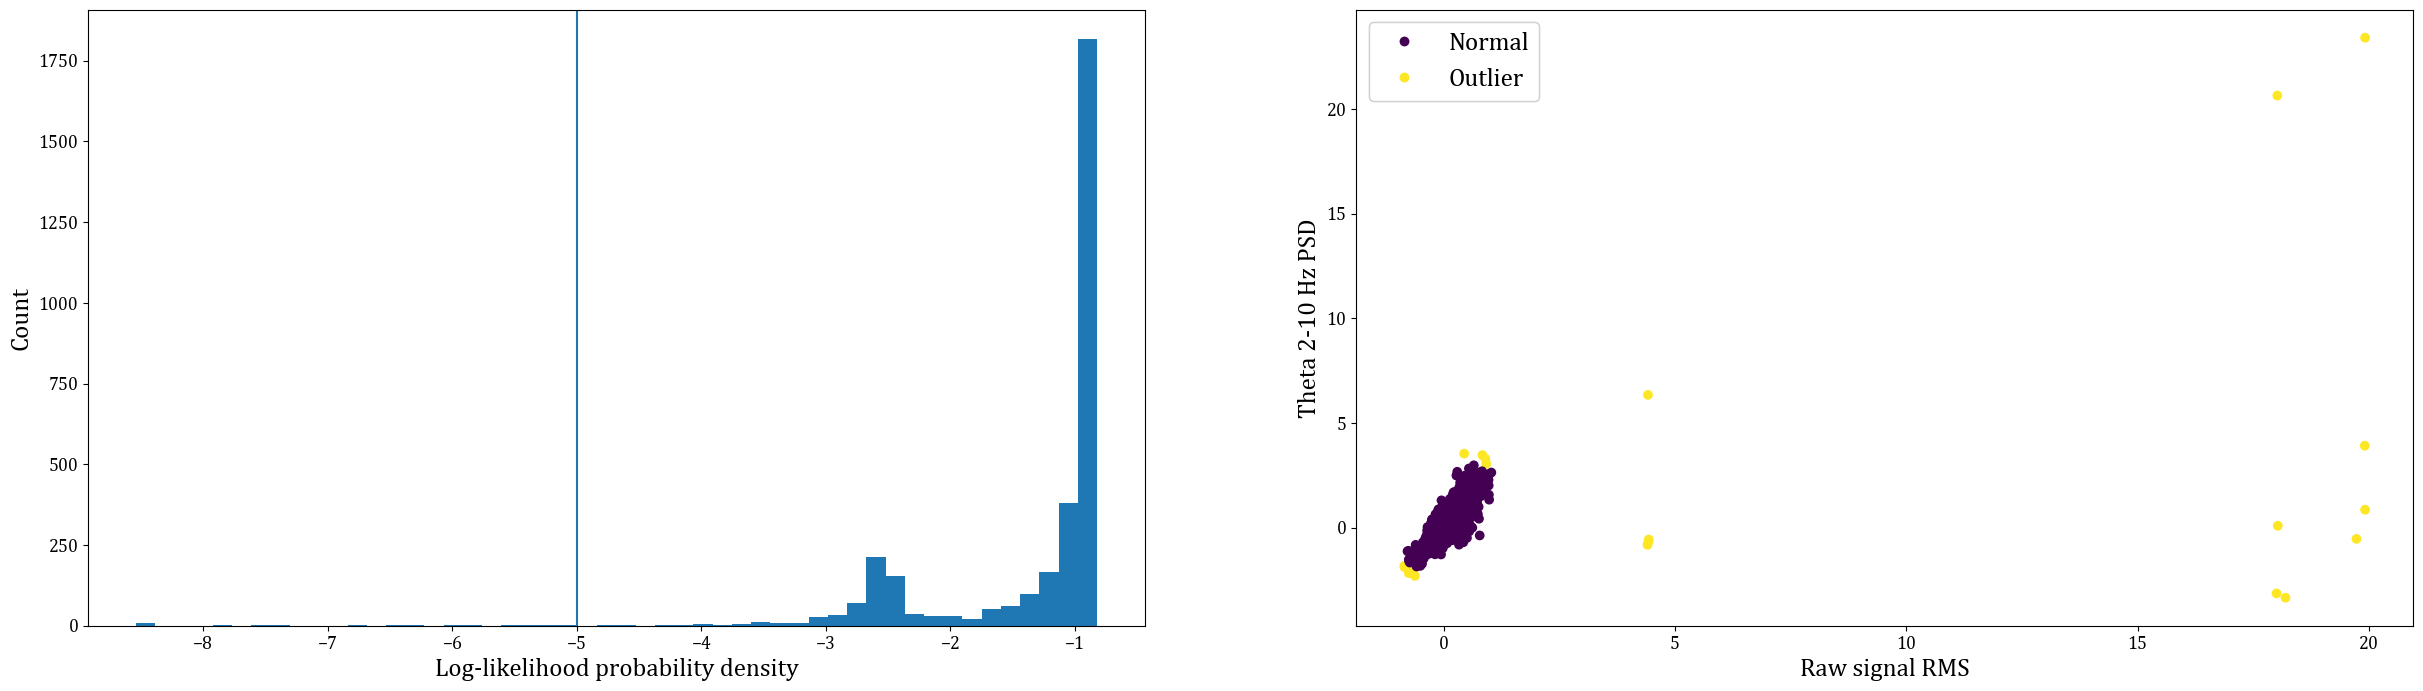

21 artefacts detected by Epanechnikov


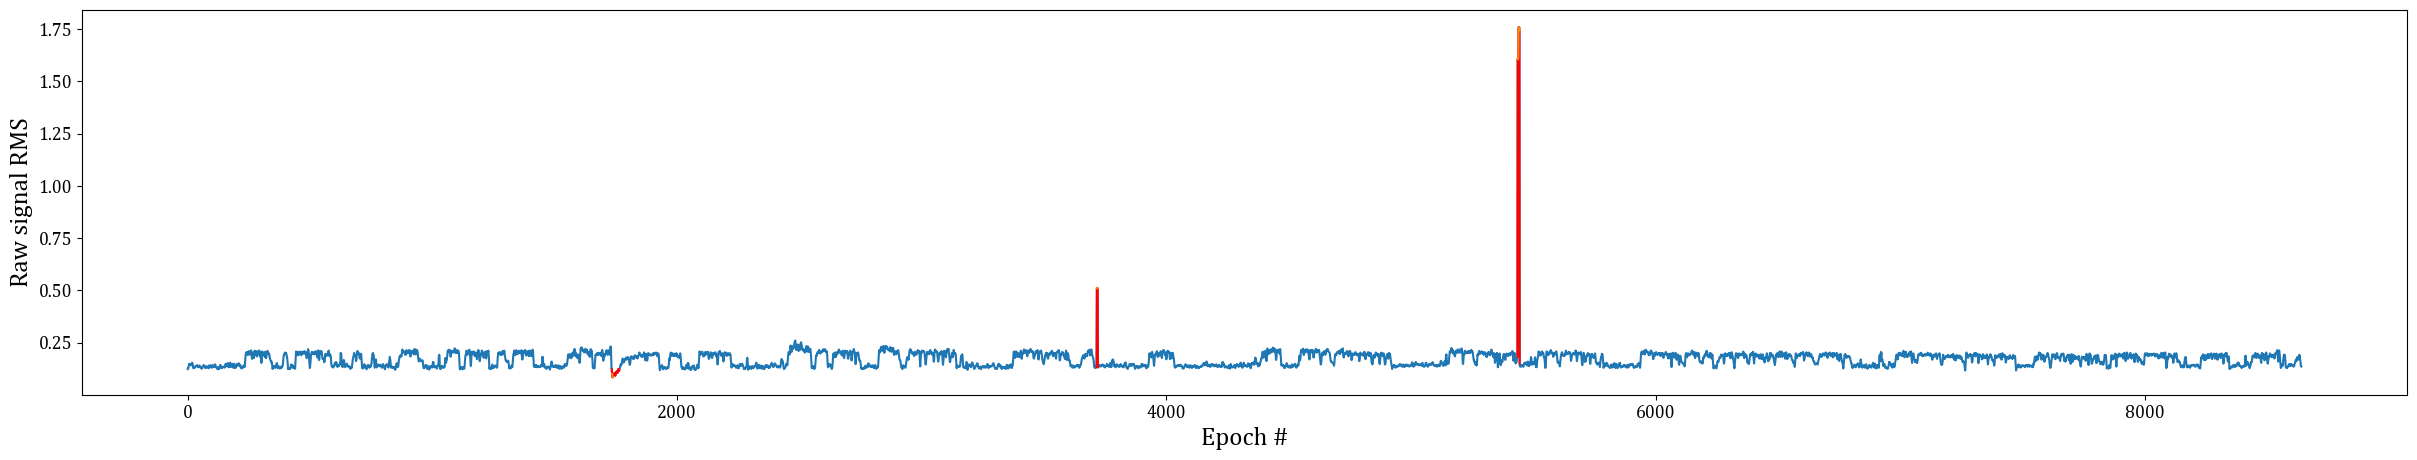

47 artefacts detected by thresholds


In [5]:
force_art_thr = [False]     # False/None or (lower_threshold, upper_threshold) for extremely high/low-amplitude artifact detection for each animal/channel in the recording
w_humps = 150               # smoothing window (sec) for additional smoothing of the raw signal RMS for Wake epochs reduction
zbefore, oafter = 1, 40     # minimum number of epochs under the threshold before its crossing to consider the crossing; how many epochs after the crossing are removed from further REM identification 
ridge_thrs = [[None, None]] # the mode for threshold setting when reducing Wake epochs: for each animal, it should be either iterable of only None values or only numbers; None implies automatic threshold setting, while numbers imply 
                            # the thresholds themselves; the length of the iterable implies into how many parts the data should be split and separate thresholds are set for each of them
Ep = [-5]                   # if cluster_artifact is enabled, this defines the density threshold (-5 by default and usually OK)
verbose = 2                 # can be locally adjusted for more graphs particularly at this analysis step

refined_ridges, fad, scorer_class.INITIAL_RIDGES = None, None, {}
vote_dict, scorings = scorer_class.prescoring_artifacts(vote_dict, scorings, verbose=verbose, cluster_artifact=cluster_artifact, expert_hypnos=expert_hypnos, force_art_thr=force_art_thr, w_humps=w_humps, ep=Ep, zbefore=zbefore, \
                                                        oafter=oafter, ridge_thrs=ridge_thrs, refined_ridges=refined_ridges, fad=fad)

# NREM sleep identification

In [6]:
vote_dict = scorer_class.prescoring_nrem(vote_dict, scorings, visualize_clusters=visualize_clusters, expert_hypnos=expert_hypnos, verbose=verbose, fad=fad)

File "mouse_1.smr"
Animal 0
Day 0



# Day-wise REM sleep identification
### - using Wake-reduced epochs, for each BC, remove the NREM cluster first and then separate the remaining Wake and REM epochs

In [7]:
rough_separation = [False] # the mode of NREM cluster removal in each BC: either False/None (automatic GMM-based) or a number (rigid threshold); 
fname = fnames[0]          # pick the filename of interest 
animal = 0                 # pick the animal/channel of interest
day = 0                    # pick the day of interest
show_plot = False          # whether to show detailed BC scatters or not (sort of local 'verbose') 

fad = (fname, animal, day)
scoring = scorings[fname][animal][day]
vote_dict[fname][animal][day][5] = scorer_class.INITIAL_RIDGES.get(fname, {}).get(animal, [None]*(day + 1))[day]
scoring.nr_mask = scorer_class.INITIAL_RIDGES.get(fname, {}).get(animal, [None]*(day + 1))[day]

vote_dict_, scoring = scorer_class.prescoring_theta_comb(vote_dict, scoring, expert_hypnos=expert_hypnos, rough_separation=rough_separation, show_plot=show_plot, delta_theta_combs=delta_theta_combs, fad=fad)
vote_dict[fname][animal][day] = vote_dict_[fname][animal][day]
to_ave_bcp, cl_nms_bcp, figsave_bcp = deepcopy(scorer_class.TO_AVE), list(scorer_class.CLUSTER_NAMES), deepcopy(scorer_class.FIGSAVE)

File "mouse_1.smr"
Animal 0
Day 0


  0%|                                                                                                         …

### - to reduce FN REM, force all the epochs inside the averaged REM cluster to be REM

In [8]:
manual_contour = True                                  # True - interactive selection of REM cluster, False - automatic GMM-based selection (the result is the std ellipse)
ellipse_magnify = 1.5                                   # magnification of the resulting ellipse if manual_contour=False
rule = [len(delta_theta_combs)] * len(vote_dict[fname]) # stringency for REM identification voting over BCs for each animal/channel (recommended = number of BCs)

selection, selection2 = None, None 
scoring = scorings[fname][animal][day]
scorer_class.TO_AVE, scorer_class.CLUSTER_NAMES = to_ave_bcp, cl_nms_bcp
hypno_labels, last_hypnos = scorer_class.precontour_init(hypno_labels, last_hypnos, fname, animal, day)
(img, selection, contour), hypno_labels[fname][animal][day], last_hypnos[fname][animal][day] = scorer_class.end_scoring_selection(vote_dict, fname, animal, day, scoring, rule, single_nr, single_wake, \
                                                                                      spindles=spindles, manual_contour=manual_contour, vote_pass=np.arange(len(delta_theta_combs)), ellipse_magnify=ellipse_magnify, selection=selection) 
img

Animal 0
Day 0
voting using 30 clusters. rule = 30
20 2-long or shorter NREM epochs corrected
Wake - 770; NREM - 4135; REM - 480; 


:Overlay
   .NdOverlay.I :NdOverlay   [stage]
      :Scatter   [Theta]   (~Delta,state)
   .Polygons.I  :Polygons   [x,y]

In [9]:
# save result after the patch drawing (doesn't matter manual or automatic)
selection_transfer = np.zeros(len(scoring.nr_mask))
nr_sel = selection_transfer[scoring.nr_mask]
df, vertices = scorer_class.av_bcs_df(fname, animal, day, hypno_labels), None
if len(contour.data['xs']) > 0:
    vertices = np.array(list(zip(contour.data['xs'][-1], contour.data['ys'][-1]))).reshape((-1, 2))
    if manual_contour: selection = scorer_class.process_polygon_selection(contour, df)
    print(f'{np.where(hypno_labels[fname][animal][day][selection] != 2)[0].size} points forced to REM')
    hypno_labels[fname][animal][day][selection], nr_sel[selection] = 2, 1
    selection_transfer[scoring.nr_mask] = nr_sel 

# If necessary make a reversed patch that will get rid of FP REM epochs after the previous patch (only manual makes sense here)

In [10]:
df['state'] = hypno_labels[fname][animal][day]
img, selection2, contour2 = scorer_class.sel_scatter(df, True)
img

:Overlay
   .NdOverlay.I :NdOverlay   [stage]
      :Scatter   [Theta]   (~Delta,state)
   .Polygons.I  :Polygons   [x,y]

In [11]:
# save result after the patch drawing
vertices2 = None
if len(contour2.data['xs']) > 0:
    vertices2, selection2 = np.array(list(zip(contour2.data['xs'][-1], contour2.data['ys'][-1]))).reshape((-1, 2)), scorer_class.process_polygon_selection(contour2, df)
    relabel = scorer_class.nearest_w_nr(selection2, df)
    print(f'{np.where(hypno_labels[fname][animal][day][selection2] == 2)[0].size} REM points -> (W, NREM)')
    hypno_labels[fname][animal][day][selection2], selection2_transfer = relabel[:, None], np.zeros(len(scoring.nr_mask))
    nr_sel = selection2_transfer[scoring.nr_mask]
    nr_sel[selection2] = 1
    selection2_transfer[scoring.nr_mask] = nr_sel

# Finishind the 1st iteration ang getting 3-state hypnogram and some stats

Before contextual rules:
0 REMs turned to Wake in the very beginning
35 REMs turned to Wake by analyzing preceding states
0 single NREMs between REMs and REMs corrected
31 single Wakes between REMs and REMs corrected
26 1-long or shorter REM epochs corrected
58 REM epochs removed due to at least 2 preceding Wake epochs (old n_back)


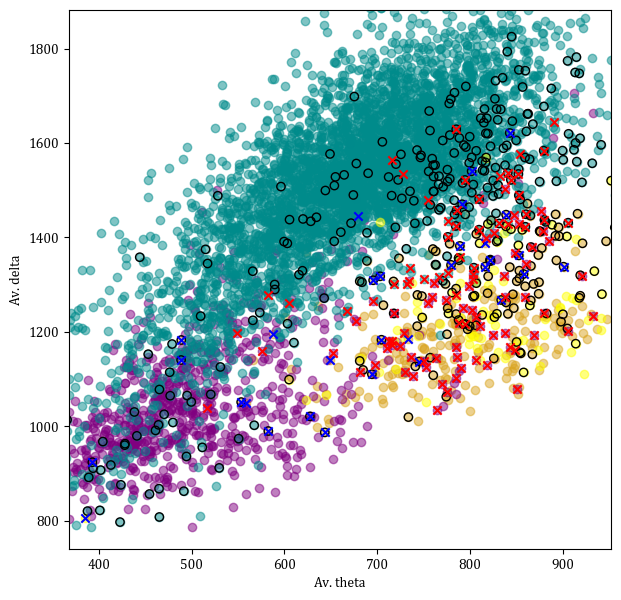

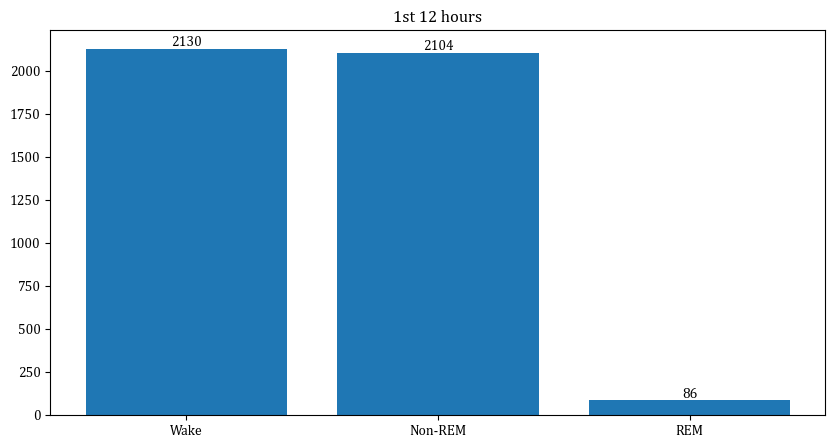

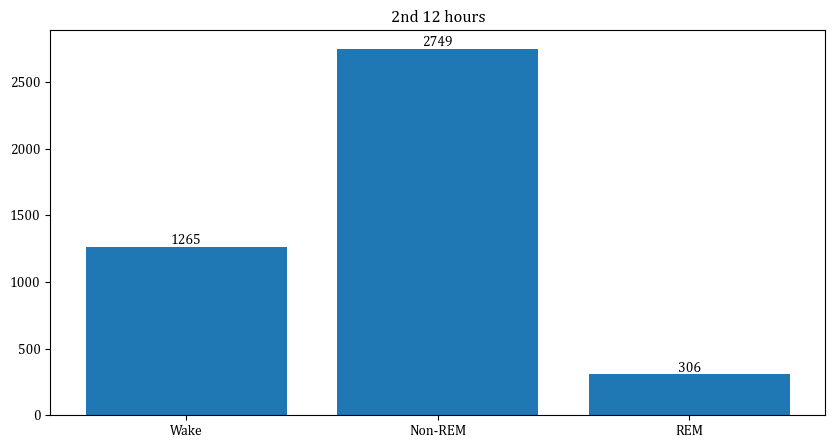

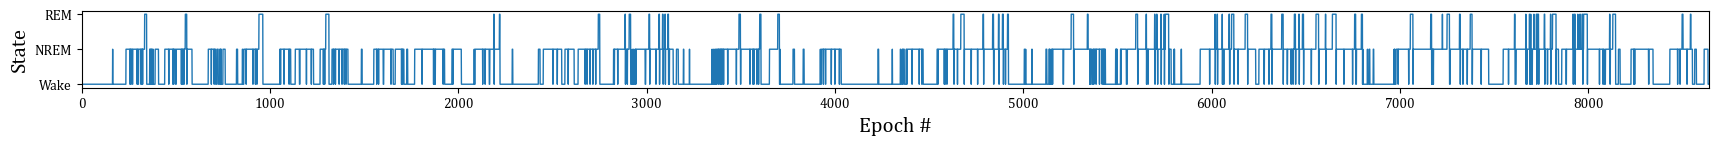

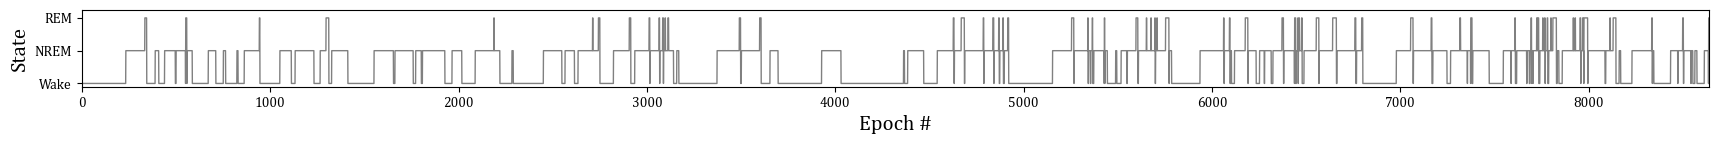

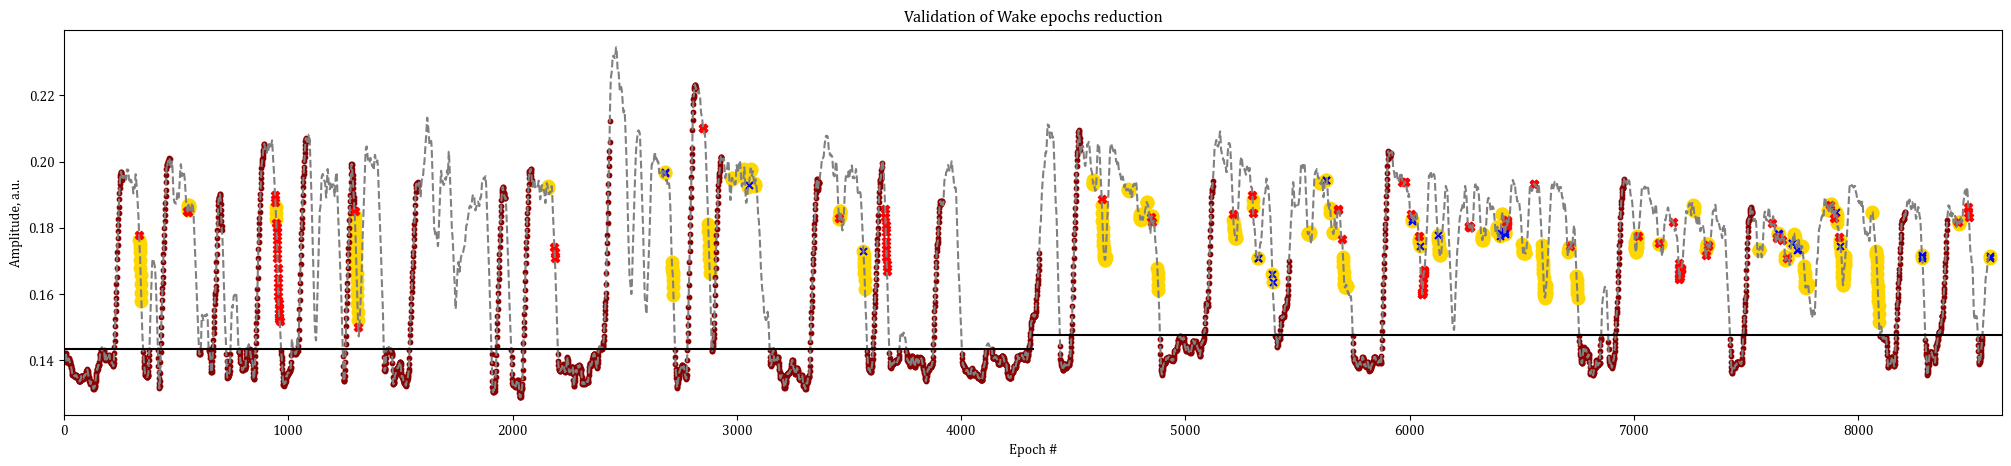

2876 more points will be removed between detected REM and ridge-removed points
General accuracy = 0.93
Balanced accuracy = 0.88
General Cohen's kappa = 0.86
F1 = 0.92
Confusion matrix:
[[3107  291    9]
 [ 214 4527   24]
 [  74   35  359]]
Accuracies by class: 0.91, 0.95, 0.77
Sensitivities by class: 0.91 0.95 0.77
Specificities by class: 0.94 0.92 1.00
Cohen's kappas by class: 0.86 0.87 0.83
F1 by class: 0.91 0.94 0.83


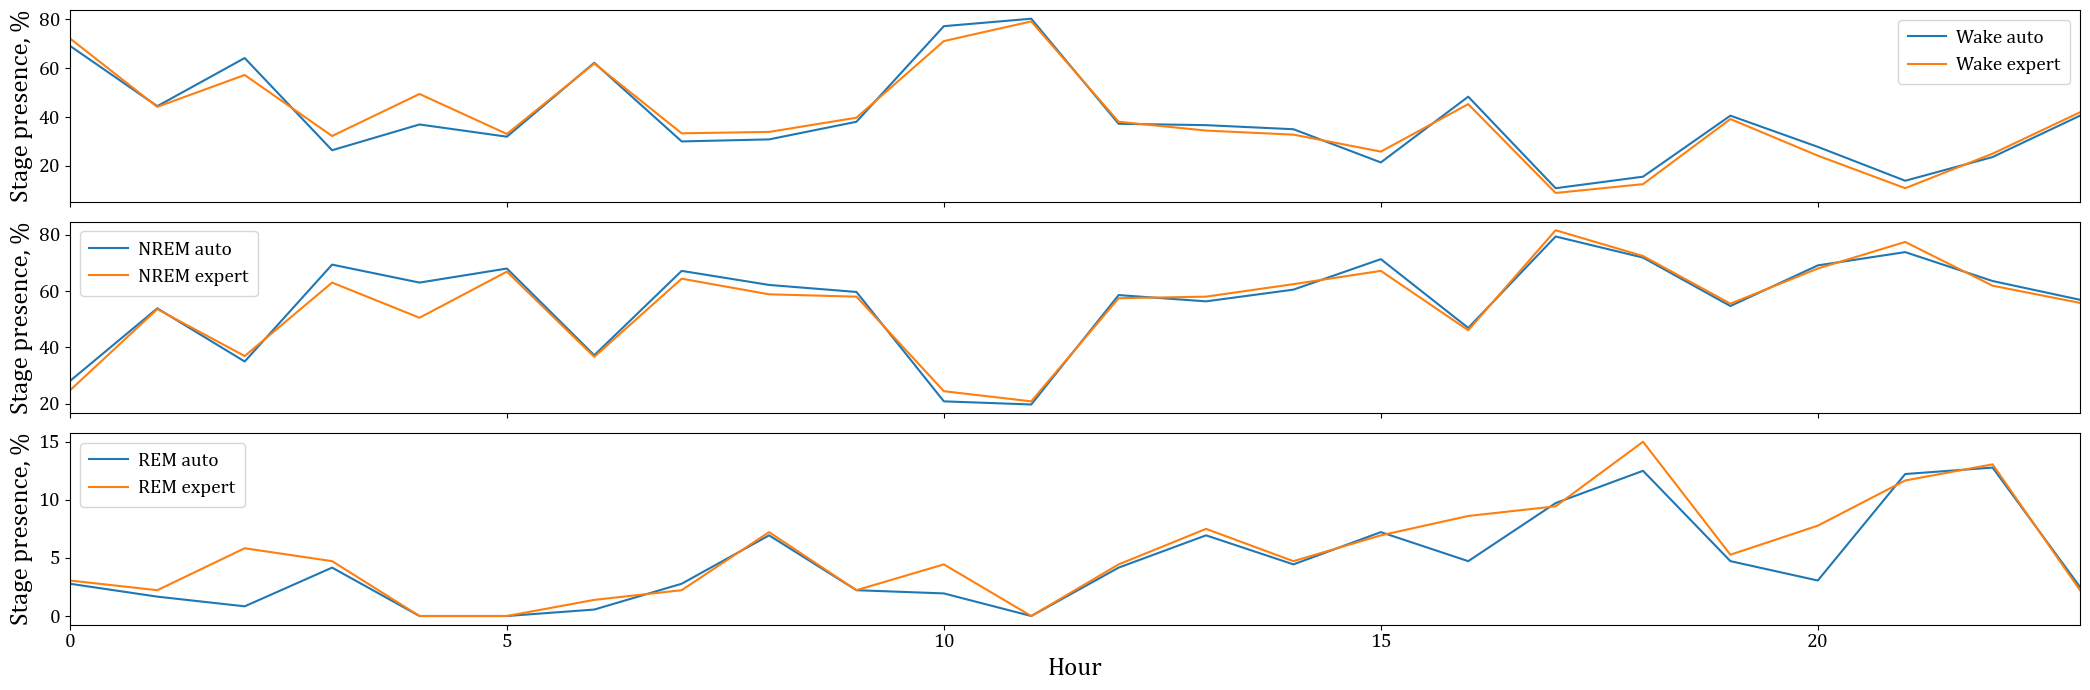

In [12]:
# some more params concerning contextual rules
n_back, wake_thr = 20, 5                              # how many epochs before REM are checked (can also be None/False); how many of them should be Wake to cancel the whole REM episode
clear_start_rem = True                                # whether to cancel REM if the hypnogram starts with this stage
n_back_old = 2                                        # how many Wake epochs should immediately preceed REM to cancel this REM episode (can be none/False)
more_reduce = True                                    # whether to remove more epochs between previously Wake-reduced ones and the REM identified before 2nd iteration

# visualisation params
save_spec_params = {'ranges': [], 'window_sec': 3600}                                             # if stage-colored plots of FFT values are needed, list the 2-value iterables with frequencies of interest in 'ranges'; 
                                                                                                  # use 'window_sec' to set the averaging window (sec) for the same data to be further saved in csv 
save_spec_params['spec_max'] = [[None] * len(save_spec_params['ranges'])] * len(vote_dict[fname]) # use 'spec_max' to set the OY max values in the corresponding plots in case of outliers (automatic by default)
verbose = 2                                           # another local verbosity parameter
rnr_edges = 2                                         # for research purposes, the number of NREM epochs neighboring REM epochs to be indicated as black circles in the averaged BC scatter plot

              
scorer_class.TO_AVE, scorer_class.CLUSTER_NAMES, scorer_class.FIGSAVE = to_ave_bcp, cl_nms_bcp, figsave_bcp
fracs, fragms, hypnos, saved_specs = scorer_class.prefinish_init(fracs, fragms, hypnos, saved_specs, fname, animal)
to_interactive, frac_, fragm_, hypn_, sasp_, refined_ridges = scorer_class.end_scoring_final(vote_dict, fnames, scoring, n_hours_cycle_bars, minutes, hours_fragm, expert_hypnos, verbose, hypno_labels, last_hypnos, n_back, wake_thr, \
                                                                                             single_nrem2_1_2, single_wake2_0_2, single_r, n_back_old, save_spec_params=save_spec_params, get_particular=(fname, animal, day), \
                                                                                             save_dir=save_dir, clear_start_rem=clear_start_rem, more_reduce=more_reduce, rnr_edges=rnr_edges)
fracs[fname][animal][day], fragms[fname][animal][day], hypnos[fname][animal][day], saved_specs[fname][animal][day] = frac_[fname], fragm_[fname], hypn_[fname][0], sasp_[fname][animal][0]
figsave_bcp = deepcopy(scorer_class.FIGSAVE)

# Second iteration to refine REM (optional, but proceed to the very last cell to save results in files)
### formally all the analysis steps are repeated up to REM identification, although not almost none of the calculations are not repeated if not necessary

In [13]:
vote_dict_, scorings_ = scorer_class.prescoring_artifacts(vote_dict, scorings, verbose=0, cluster_artifact=cluster_artifact, expert_hypnos=expert_hypnos, force_art_thr=force_art_thr, w_humps=w_humps, ep=Ep, zbefore=zbefore, oafter=oafter,\
                                                          ridge_thrs=ridge_thrs, refined_ridges=refined_ridges, fad=fad)
vote_dict_ = scorer_class.prescoring_nrem(vote_dict_, scorings_, visualize_clusters=visualize_clusters, expert_hypnos=expert_hypnos, verbose=verbose, fad=fad)
vote_dict, scoring = scorer_class.prescoring_theta_comb(vote_dict_, scorings_[fname][animal][day], expert_hypnos=expert_hypnos, rough_separation=rough_separation, show_plot=show_plot, delta_theta_combs=delta_theta_combs, fad=fad)
to_ave_bcp, cl_nms_bcp, figsave_bcp = deepcopy(scorer_class.TO_AVE), list(scorer_class.CLUSTER_NAMES), deepcopy(scorer_class.FIGSAVE)

File "mouse_1.smr"
Animal 0
Day 0
22 artefacts detected by Epanechnikov
16 artefacts detected by thresholds
File "mouse_1.smr"
Animal 0
Day 0

File "mouse_1.smr"
Animal 0
Day 0


  0%|                                                                                                         …

### - to reduce FN REM, force all the epochs inside the averaged REM cluster to be REM

In [14]:
manual_contour = True # True - interactive selection of REM cluster (you can new otherwise it will be transferred from the first iteration regardless of whether it was manually drawn or autimatically!);
                      # False - automatic GMM-based selection (this will provide NEW automatic elliptic selection)
                      # To avoid any selection, set manual_contour = True and uncomment 'vertices = None' here
ellipse_mahnify = 1.5 # magnification of the resulting ellipse if manual_contour=False

scoring = scorings[fname][animal][day]
scorer_class.TO_AVE, scorer_class.CLUSTER_NAMES = to_ave_bcp, cl_nms_bcp
hypno_labels, last_hypnos = scorer_class.precontour_init(hypno_labels, last_hypnos, fname, animal, day)
(img, selection_, contour_), hypno_labels[fname][animal][day], last_hypnos[fname][animal][day] = scorer_class.end_scoring_selection(vote_dict, fname, animal, day, scoring, rule, single_nr, single_wake, \
                                                                                      spindles=spindles, manual_contour=manual_contour, vote_pass=np.arange(len(delta_theta_combs)), ellipse_magnify=ellipse_magnify, selection=vertices) 
img

Animal 0
Day 0
voting using 30 clusters. rule = 30
3 2-long or shorter NREM epochs corrected
Wake - 499; NREM - 2058; REM - 3; 


:Overlay
   .NdOverlay.I :NdOverlay   [stage]
      :Scatter   [Theta]   (~Delta,state)
   .Polygons.I  :Polygons   [x,y]

In [19]:
# save result after the patch drawing (doesn't matter manual or automatic)
df = scorer_class.av_bcs_df(fname, animal, day, hypno_labels)
if manual_contour:
    if len(contour_.data['xs']) > 0: contour = contour_
    if len(contour.data['xs']) > 0: selection = scorer_class.process_polygon_selection(contour, df)
    else: selection = []
print(f'{np.where(hypno_labels[fname][animal][day][selection] != 2)[0].size} points forced to REM')
hypno_labels[fname][animal][day][selection] = 2

0 points forced to REM


# If necessary make a reversed patch that will get rid of FP REM epochs after the previous patch (only manual makes sense here)

In [20]:
# if you don't draw anything here, the reversed patch will be transfered from the first iteration
df['state'] = hypno_labels[fname][animal][day]
img, selection2_, contour2_ = scorer_class.sel_scatter(df, True, selection=vertices2)
img

:Overlay
   .NdOverlay.I :NdOverlay   [stage]
      :Scatter   [Theta]   (~Delta,state)
   .Polygons.I  :Polygons   [x,y]

In [21]:
# save result after the patch drawing
if len(contour2_.data['xs']) > 0: contour2 = contour2_
if len(contour2.data['xs']) > 0:
    selection2 = scorer_class.process_polygon_selection(contour2, df)
    relabel = scorer_class.nearest_w_nr(selection2, df)
    print(f'{np.where(hypno_labels[fname][animal][day][selection2] == 2)[0].size} REM points -> (W, NREM)')
    hypno_labels[fname][animal][day][selection2] = relabel[:, None]

# Finishind the 1st iteration ang getting 3-state hypnogram and some stats

Before contextual rules:
0 REMs turned to Wake in the very beginning
1 REMs turned to Wake by analyzing preceding states
0 single NREMs between REMs and REMs corrected
0 single Wakes between REMs and REMs corrected
2 1-long or shorter REM epochs corrected


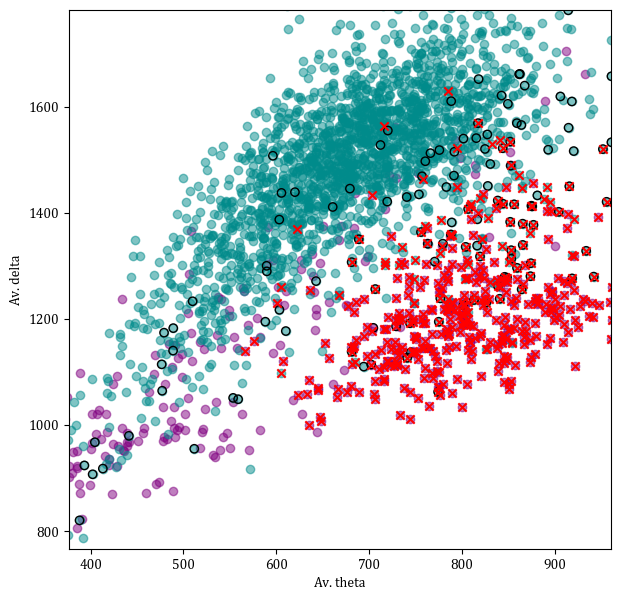

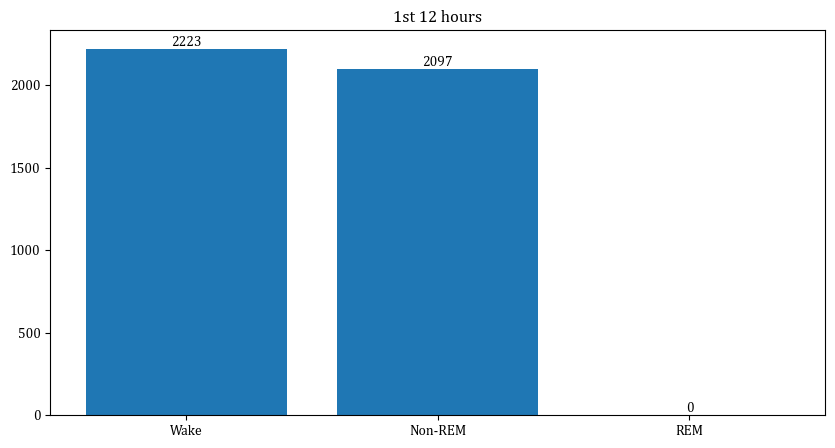

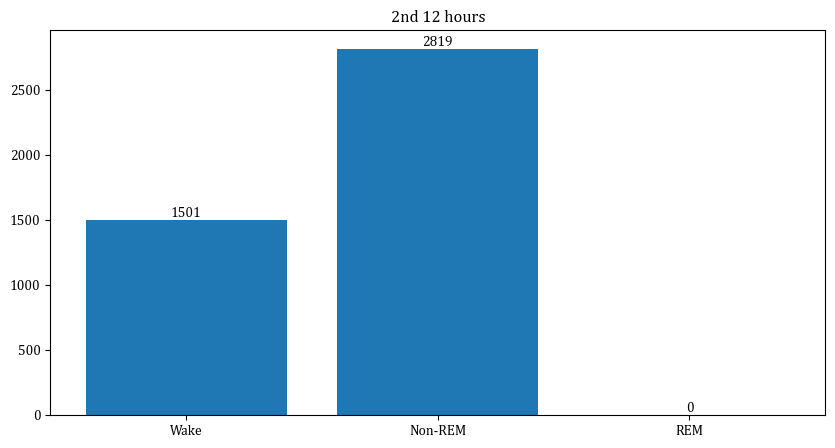

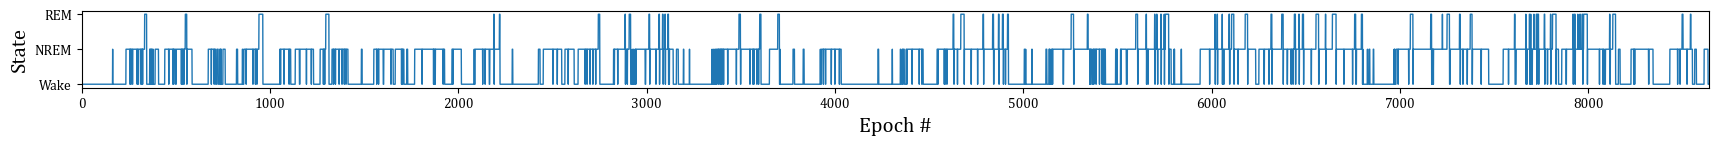

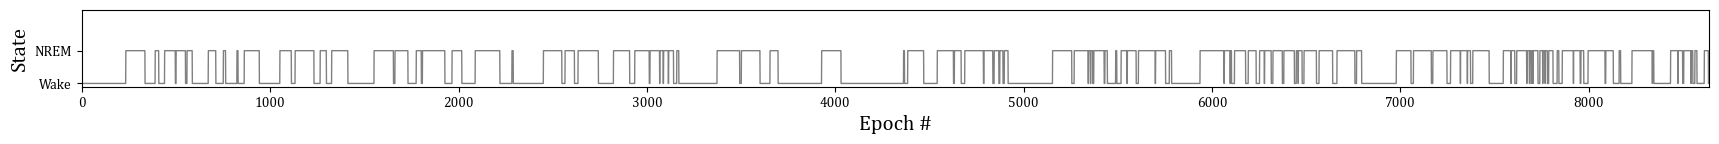

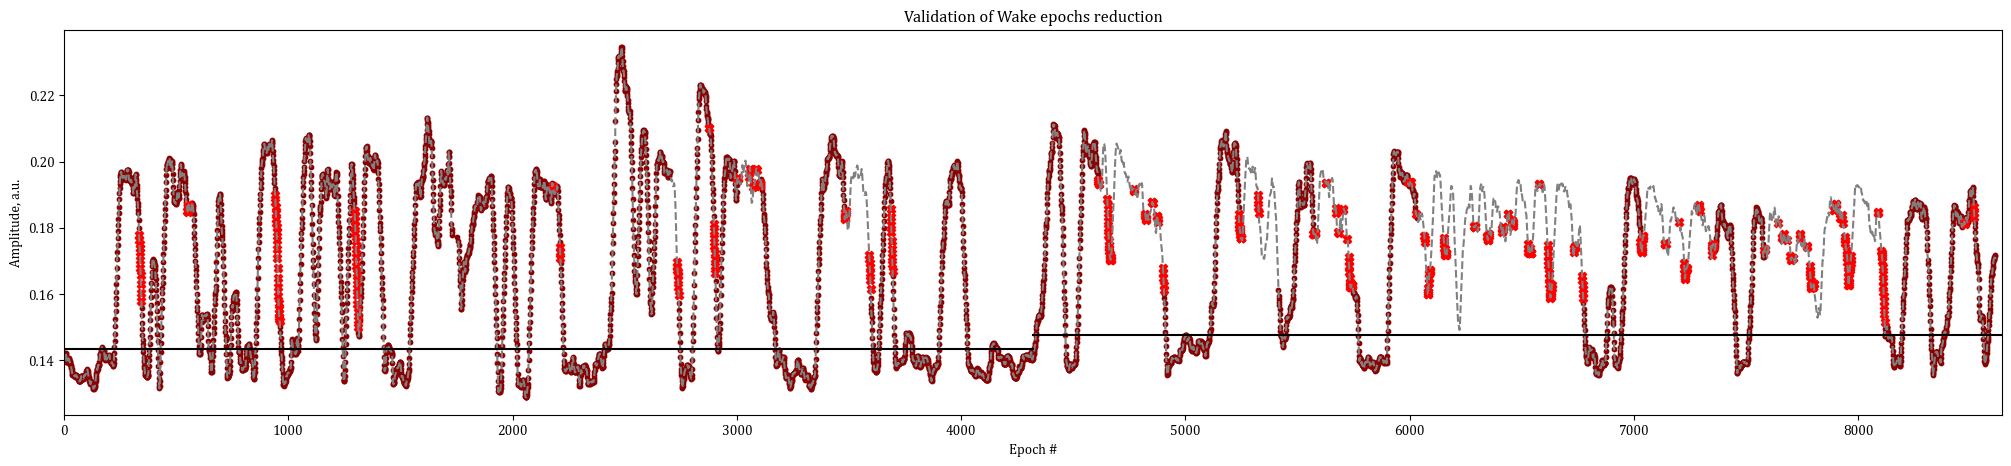

2609 more points will be removed between detected REM and ridge-removed points
General accuracy = 0.89
Balanced accuracy = 0.62
General Cohen's kappa = 0.78
F1 = 0.86
Confusion matrix:
[[3138  269    0]
 [ 222 4543    0]
 [ 364  104    0]]
Accuracies by class: 0.92, 0.95, 0.00
Sensitivities by class: 0.92 0.95 0.00
Specificities by class: 0.89 0.90 1.00
Cohen's kappas by class: 0.80 0.86 0.00
F1 by class: 0.88 0.94 0.00


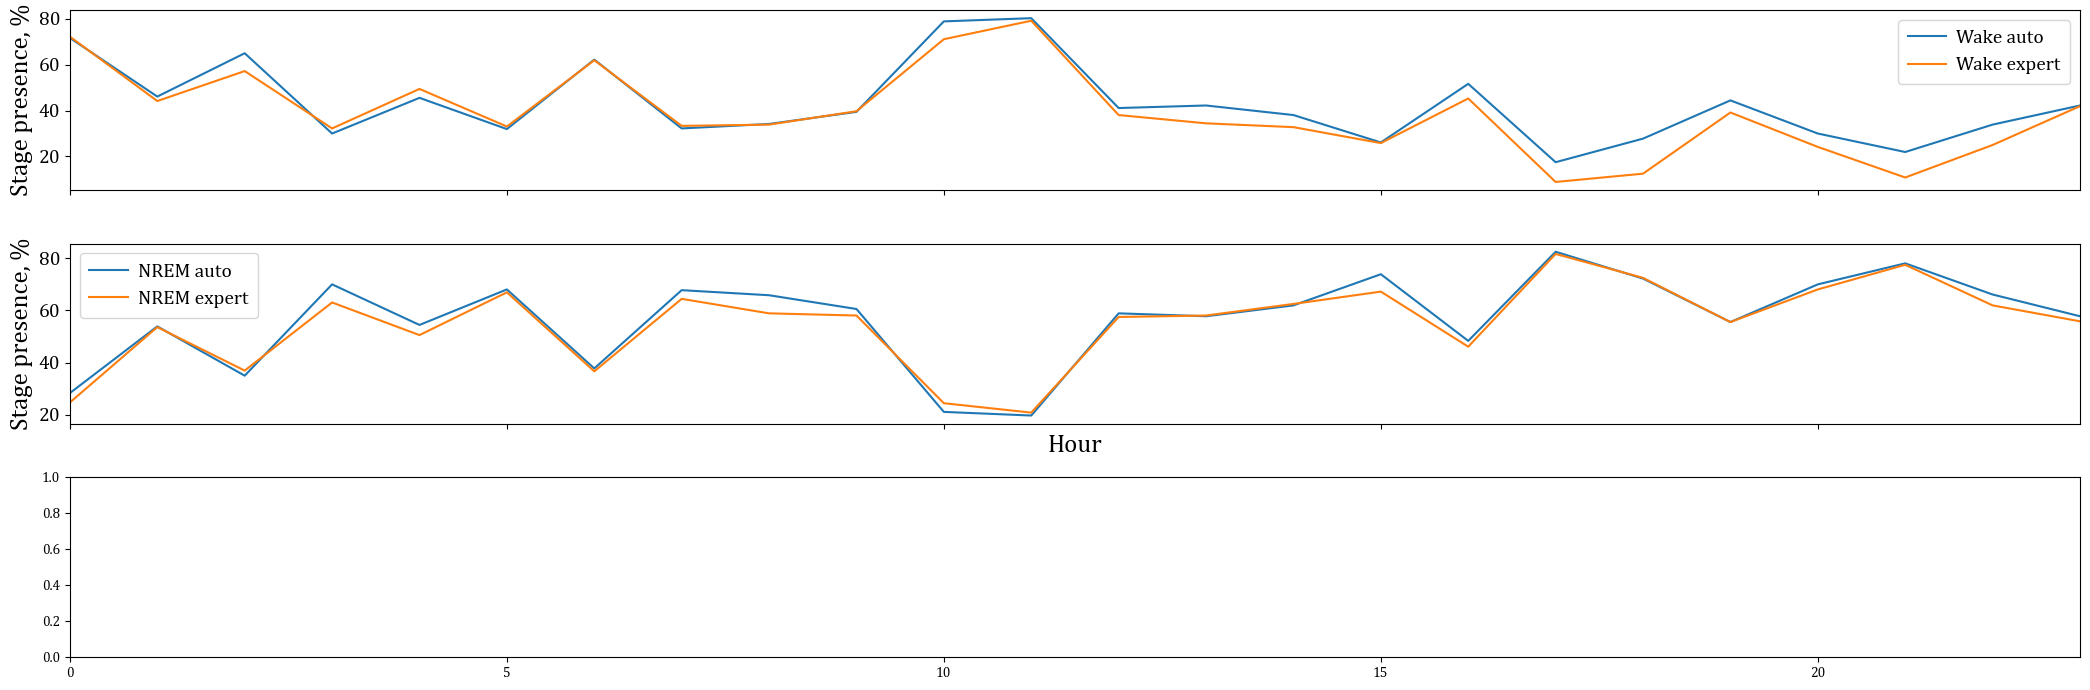

In [22]:
n_back_old = False # makes sense to disable this time
verbose = 2        # another local verbosity parameter

scorer_class.TO_AVE, scorer_class.CLUSTER_NAMES, scorer_class.FIGSAVE = to_ave_bcp, cl_nms_bcp, figsave_bcp
fracs, fragms, hypnos, saved_specs = scorer_class.prefinish_init(fracs, fragms, hypnos, saved_specs, fname, animal)
to_interactive, frac_, fragm_, hypn_, sasp_, refined_ridges = scorer_class.end_scoring_final(vote_dict, fnames, scoring, n_hours_cycle_bars, minutes, hours_fragm, expert_hypnos, verbose, hypno_labels, last_hypnos, n_back, wake_thr, \
                                                                                             single_nrem2_1_2, single_wake2_0_2, single_r, n_back_old, save_spec_params=save_spec_params, get_particular=(fname, animal, day), \
                                                                                             save_dir=save_dir, clear_start_rem=clear_start_rem, more_reduce=more_reduce, rnr_edges=rnr_edges)
fracs[fname][animal][day], fragms[fname][animal][day], hypnos[fname][animal][day], saved_specs[fname][animal][day] = frac_[fname], fragm_[fname], hypn_[fname][0], sasp_[fname][animal][0]
figsave_bcp = deepcopy(scorer_class.FIGSAVE)

# After processing all days of all animals/channels in all filenames save the results

In [26]:
suffixes = {} # to mark some animals/channels from a particular file (say, 'fname'), you can provide text marks like this: {fname: {animal_index: 'x'}} 
(fracs_, fragms_, hypnos_, saved_specs_, res_ids), scorer_class.FIGSAVE = scorer_class.arange_dicts(fracs, fragms, hypnos, saved_specs), figsave_bcp
scorer_class.save_results(fnames, scoring, fracs_, fragms_, hypnos_, saved_specs_, minutes, res_ids, suffixes, save_dir=dir_)